# DeepAR Sales Only

In [1]:
# import libraries
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox
import datetime as dt
from sklearn.metrics import mean_absolute_error


In [2]:
# create sagemaker session and point to s3 buckets
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

sagemaker_session = sagemaker.Session()

s3_bucket = 'prototype-data-s'

s3_prefix = 'sagemaker/gf'   # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

In [3]:
# load sales data
data= pd.read_pickle("./all_sales_df.pkl")

In [4]:
data = data.set_index('store_item').T

In [5]:
data = data.fillna(0)

In [7]:
data['store_11_item_329365'].head()

date
2013-03-16     3.0
2013-03-17    10.0
2013-03-18     1.0
2013-03-19     0.0
2013-03-20     0.0
Name: store_11_item_329365, dtype: float64

In [8]:
num_timeseries = data.shape[1]

In [9]:
data.index = pd.to_datetime(data.index)

In [10]:
timeseries = [data.iloc[:,i] for i in range(num_timeseries)]

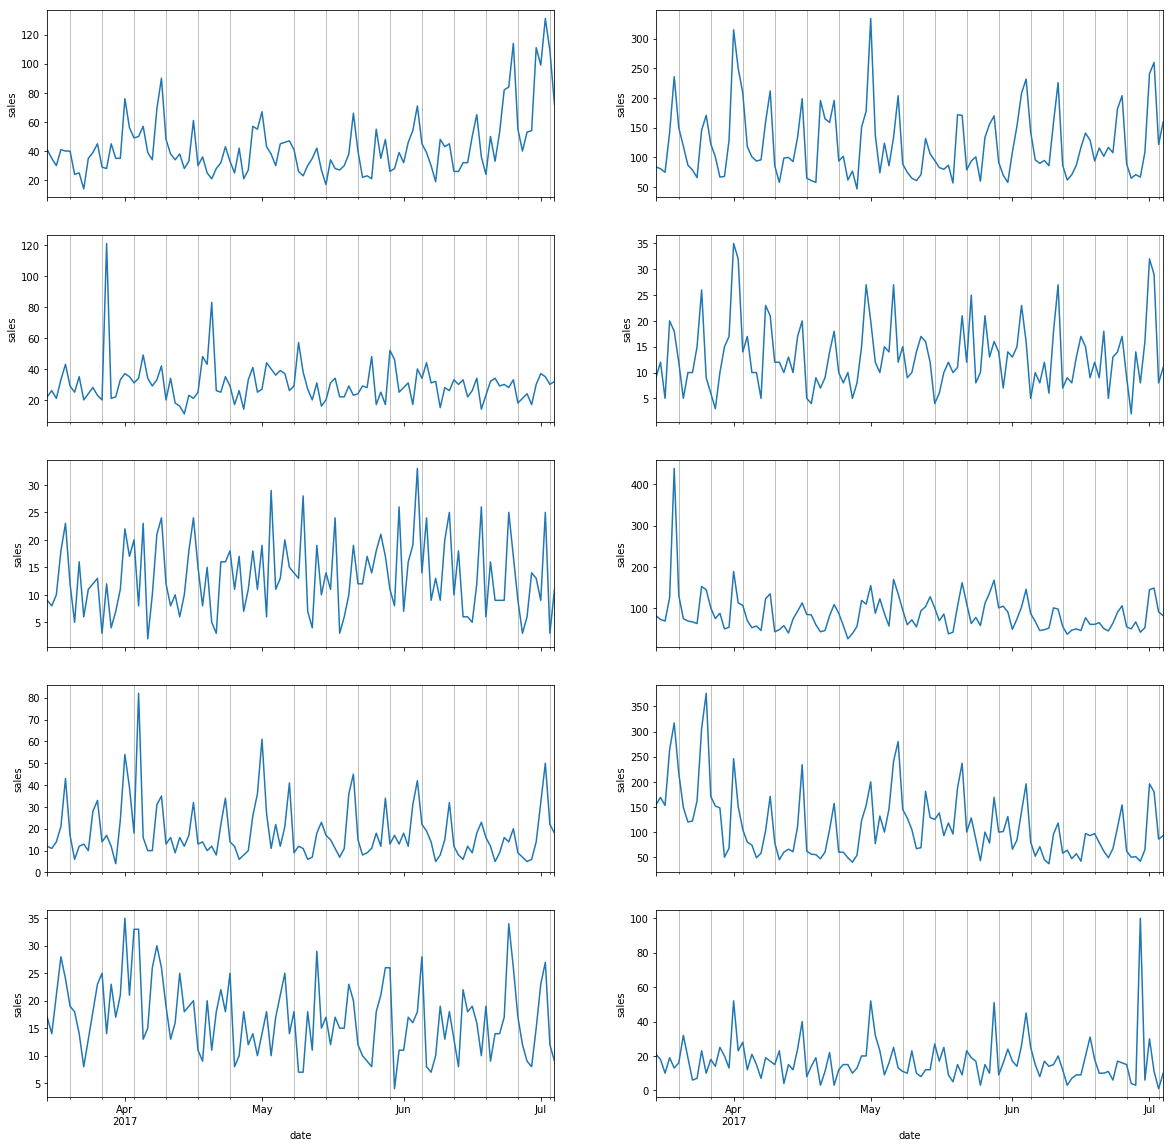

In [11]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc[data.index[-28*4:]].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("sales")   
    axx[i].grid(which='minor', axis='x')

In [12]:
# specify frequency for prediction
freq = 'D'

# predict for 14 days
prediction_length = 14

# uses 14 * 4 days of knowledge
context_length = 14 * 4

In [13]:
min(data.index), max(data.index)

(Timestamp('2013-03-16 00:00:00'), Timestamp('2017-07-04 00:00:00'))

In [14]:
# specify training and end times
end_training = pd.Timestamp(max(data.index) + dt.timedelta(days=-28*10),freq=freq)

start_dataset = pd.Timestamp( end_training + dt.timedelta(days=-28*20), freq=freq)

In [15]:
start_dataset, end_training

(Timestamp('2015-03-17 00:00:00', freq='D'),
 Timestamp('2016-09-27 00:00:00', freq='D'))

In [16]:
# from 2014-01-01 to 2014-08-31 22:00:00
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


8715


In [17]:
timeseries[0][start_dataset:end_training - 1].head(5)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  if __name__ == '__main__':


date
2015-03-17    26.0
2015-03-18    27.0
2015-03-19    19.0
2015-03-20    28.0
2015-03-21    39.0
Name: store_47_item_581078, dtype: float64

In [18]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + k * prediction_length].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]
print(len(test_data))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


34860


In [20]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [21]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 5.11 s, sys: 244 ms, total: 5.36 s
Wall time: 5.68 s


In [22]:
# copy jsons to s3
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [23]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://prototype-data-s/sagemaker/gf/data/train/train.json
Uploading file to s3://prototype-data-s/sagemaker/gf/data/test/test.json
CPU times: user 857 ms, sys: 73.4 ms, total: 930 ms
Wall time: 2.54 s


In [24]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2015-03-17 00:00:00", "target": [26.0, 27.0, 19.0, 28.0, 39.0, 35.0, 22.0, 19.0, 37.0, 25...


In [25]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='gf-ar',
    output_path=s3_output_path
)

In [26]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [27]:
estimator.set_hyperparameters(**hyperparameters)

In [1]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

In [30]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [31]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

---------------------------------------------------------------------------------------------------!

In [50]:
timeseries = [df.resample('D').sum() for df in timeseries]

In [51]:
predictor.predict(ts=timeseries[120], quantiles=[0.10, 0.5, 0.90]).head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.9,0.5
2017-07-05,10.043309,36.222237,24.306078
2017-07-06,6.642683,26.832922,18.051462
2017-07-07,8.629212,29.772909,18.050669
2017-07-08,13.627083,37.559258,24.234844
2017-07-09,13.727460,39.575897,25.783205


In [86]:
def create_maes(ts):
    preds = predictor.predict(
        ts=ts[pd.date_range(end_training + 4 * prediction_length, end_training + 5 * prediction_length)], quantiles=[0.10, 0.5, 0.90])


    preds['y']=ts[preds.index]

    return mean_absolute_error(preds['0.5'], preds['y'])

In [2]:
ts_results_df = pd.Series(
    [create_maes(ts) for ts in timeseries]
)

In [88]:
# error spread
ts_results_df.describe()

count    8715.000000
mean        8.627952
std        13.490375
min         0.074535
25%         3.003572
50%         4.775544
75%         8.938259
max       302.958325
dtype: float64